# Machine Learning Modeling Exercise


## 1. Import libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

## 2. Explore dataset

In [3]:
df_raw = pd.read_excel("Test Data analyst EDA 2023.xlsx")
df_raw.head()

,User ID,Acquired Campaign,Country,Platform,Device Model (OS),LTV Revenue,LTV Currency,Event Name,Event Date,Event Value (USD),Event Count
0,ZZZZC2DZ-982C-D4DD-C59Z-A8ZD0CBBA74F,(direct),Brazil,IOS,"iPhone9,3",NaN,NaN,user_engagement,2021-08-29,NaN,5
1,ZZZZC2DZ-982C-D4DD-C59Z-A8ZD0CBBA74F,(direct),Brazil,IOS,"iPhone9,3",NaN,NaN,screen_view,2021-08-29,NaN,4
2,ZZZZC2DZ-982C-D4DD-C59Z-A8ZD0CBBA74F,(direct),Brazil,IOS,"iPhone9,3",NaN,NaN,session_start,2021-08-29,NaN,1
3,ZZZZC2DZ-982C-D4DD-C59Z-A8ZD0CBBA74F,(direct),Brazil,IOS,"iPhone9,3",NaN,NaN,login_help_screen_open,2021-08-29,NaN,2
4,ZZZ8F57Z-9EC6-3D44-BEAA-898829Z611ZA,(direct),United States,IOS,"iPhone12,1",NaN,NaN,screen_view,2021-09-02,NaN,2


## 3. Problem Definition

If we seek to predict whether a user will engage in the `in_app_purchase` event or not, it is important to understand that this is a **classification** problem.

We wish to classify the event trigger in either:

- **YES**, it is, in fact, an `in_app_purchase` event

or

- **NO**, it is a non-purchase related event entirely.


## 4. Feature Engineering

Every `in_app_purchase` only counts as a single _Event Count_, which is why we discard every other event that > 1.


In [4]:
df_raw = df_raw[df_raw["Event Count"] == 1]

First course of action would be to create our **target variable**, which occurs when the _Event Name_ is `in_app_purchase`, through boolean values.

In [5]:
df_raw["Purchase Event"] = np.where((df_raw["Event Name"] == "in_app_purchase"), 1, 0)

We count these instances and plot them to see how many there are of each.

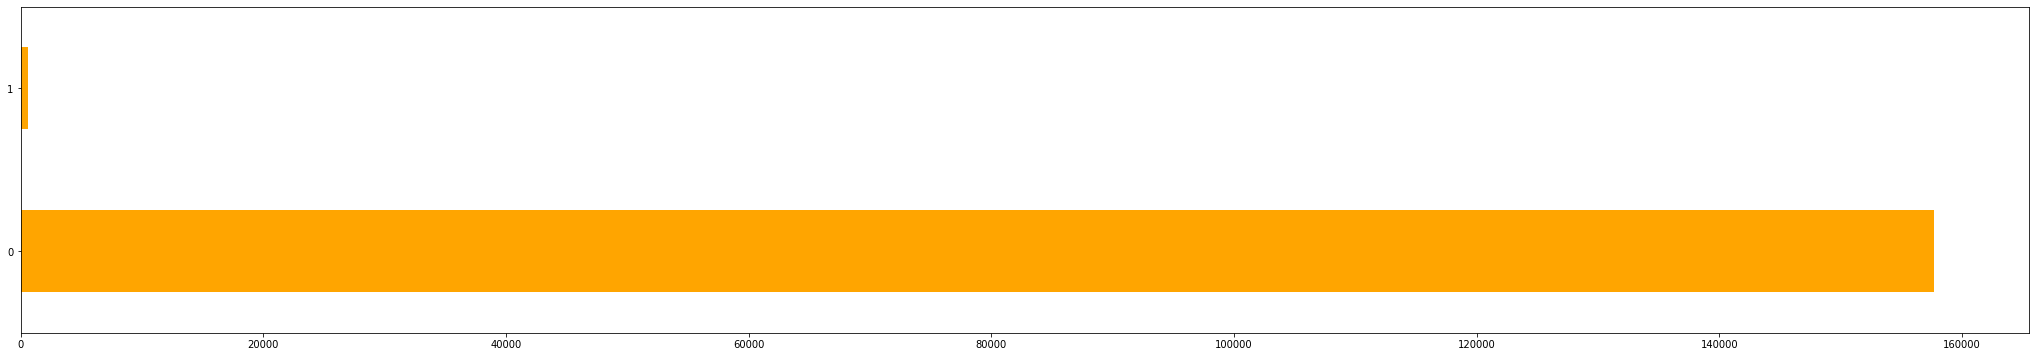

In [6]:
df1 = df_raw["Purchase Event"].value_counts()
df1.plot(kind="barh", figsize=(36, 6), color='orange')
plt.show()

Here we encounter a few problems. Our target variable is immensely **unbalanced**, at a **1:248** ratio. This will have severe repercussions when it comes to interpreting the metrics of performance of the models. Spoiler alert: be careful when settling for high accuracy!

Now onto the **regressor variables**.

There are 3 potential numeric variables: *LTV Revenue*, *Event Value (USD)* and *Event Count*.

- Event Count is already discarded due to the fact that every `in_app_purchase` event is = 1 but not all = 1 is an `in_app_purchase` event. In other words, every time Event Count is > 1, it isn't `in_app_purchase`, which means that this isn't a stochastic process. We want to know that, when it is in fact = 1, we can predict if it is `in_app_purchase`.
- Event Value (USD) has a similar issue. When Event Value (USD) isn't null, it will inevitably be an `in_app_purchase` event as a result, and vice-versa. Adding this column pretty much gives it away, because the model becomes deterministic.
- LTV Revenue, as seen in the first exercise, has an issue regarding its quality of data. It would be bad practice to include spurious variables.

This leaves us with only categoric variables to play with, which makes the task a bit more challenging.

### a. Categorization

Most of our categorical variables hold plenty of categories that could be grouped into general ones, such as the Redmi Note 8 and the Redmi Note 9 Pro being grouped simply as *Redmi*. Keeping lower categories would mean that, after the one-hot encoding process, a lot of sparse matrices will remain. This decision is made in an attempt to make the model more **parsimonious**.

- Device Models -> Mobiles

In [7]:
conditions = [
    (df_raw["Device Model (OS)"].str.contains("iP", case=False, na=False)),
    (df_raw["Device Model (OS)"].str.contains("Redmi", case=False, na=False)),
    (df_raw["Device Model (OS)"].str.contains("SM", case=False, na=False)),
]

values = ["iPhone/iPad", "Redmi", "Samsung"]
df_raw["Mobiles"] = np.select(conditions, values)

df_raw["Mobiles"] = np.where((df_raw["Mobiles"] == "0"), "Other Devices", df_raw["Mobiles"])

- Acquired Campaign -> User Source Acquisition

In [8]:
conditions = [
    (df_raw["Acquired Campaign"] == "(direct)"),
    (df_raw["Acquired Campaign"].str.contains("hard", case=False, na=False)),
    (df_raw["Acquired Campaign"].str.contains("soft", case=False, na=False)),
    (df_raw["Acquired Campaign"] == "iOS_US_Eng_Actions") | (df_raw["Acquired Campaign"] == "AND_BR_Por_Actions") | (df_raw["Acquired Campaign"] == "AND_US_Eng_Actions"),
    (df_raw["Acquired Campaign"].isnull()),
]

values = ["Direct", "Hard", "Soft", "Other Sources", "Not categorzied"]
df_raw["User Source Acquisition"] = np.select(conditions, values)

- Country -> Countries Grouped

In [9]:
conditions = [
    (df_raw["Country"] == "United States"),
    (df_raw["Country"] == "Brazil"),
    (df_raw["Country"] == "Canada"),
]

values = ["United States", "Brazil", "Canada"]
df_raw["Countries Grouped"] = np.select(conditions, values)
df_raw["Countries Grouped"] = np.where(df_raw["Countries Grouped"] == "0", "Rest of World", df_raw["Countries Grouped"])

### b. One-hot Enconding

In [10]:
ex1 = df_raw[["User Source Acquisition", "Countries Grouped", "Platform", "Mobiles", "Purchase Event"]]

var = ex1[["User Source Acquisition", "Countries Grouped", "Platform", "Mobiles"]]
var = pd.get_dummies(var, drop_first=True)

### c. Train Test Split

In [11]:
y = ex1["Purchase Event"].values
x = var

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

## 5. Modelization

We're going to try 2 popular and proven classification models typically used in similar context: *Logistic Regression* and *Random Forest*.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31543
           1       0.00      0.00      0.00       120

    accuracy                           1.00     31663
   macro avg       0.50      0.50      0.50     31663
weighted avg       0.99      1.00      0.99     31663

ROC: 0.5


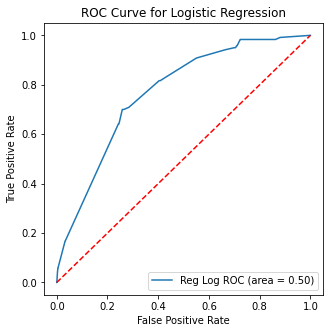

In [12]:
Reg_Log = LogisticRegression(random_state=10, max_iter=500).fit(x_train, y_train)

predict_Reg_Log = Reg_Log.predict(x_test)

ROC_Reg_Log = roc_auc_score(y_test, predict_Reg_Log)
print(metrics.classification_report(y_test, predict_Reg_Log))
print("ROC:", ROC_Reg_Log)

fpr, tpr, thresholds = roc_curve(y_test, Reg_Log.predict_proba(x_test)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label="Reg Log ROC (area = %0.2f)" % ROC_Reg_Log)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.savefig("Reg Log")
plt.show()

Logistic Regressions are one of the most simple classification models, with its greatest virtue being its power of interpretability to facilitate decision-making. Neverthelss, its predictive power is not too strong nor our data follows a linear structure, which is why we're now trying a Random Forest.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31543
           1       0.00      0.00      0.00       120

    accuracy                           1.00     31663
   macro avg       0.50      0.50      0.50     31663
weighted avg       0.99      1.00      0.99     31663

ROC: 0.5


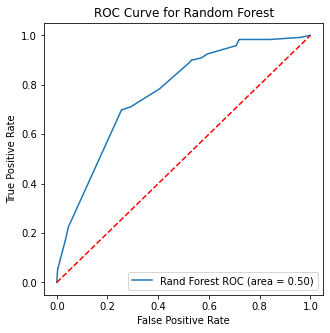

In [13]:
Rand_Forest_clasif = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    min_samples_split=5,
    max_depth=30,
    max_features="sqrt",
    bootstrap=True,
)

Rand_Forest_clasif.fit(x_train.values, y_train)

y_pred_Rand_Forest = Rand_Forest_clasif.predict(x_test.values)

ROC_Rand_Forest = roc_auc_score(y_test, y_pred_Rand_Forest)
print(classification_report(y_test, y_pred_Rand_Forest))
print("ROC:", ROC_Rand_Forest)

fpr, tpr, thresholds = roc_curve(y_test, Rand_Forest_clasif.predict_proba(x_test.values)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label="Rand Forest ROC (area = %0.2f)" % ROC_Rand_Forest)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest")
plt.legend(loc="lower right")
plt.savefig("Rand Forest")
plt.show()

Although being a simple yet stronger model when it comes to prediction, while also handling non-linear data structures, we couldn't make progress in terms of results.

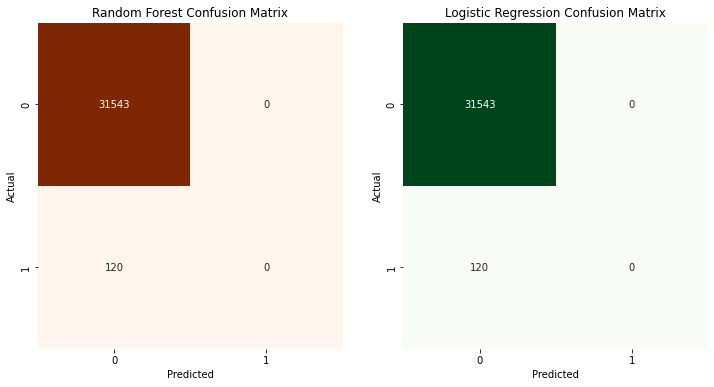

In [14]:
ran = confusion_matrix(y_test, y_pred_Rand_Forest)
log = confusion_matrix(y_test, predict_Reg_Log)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(log, annot=True, fmt="d", cmap="Oranges", cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Random Forest Confusion Matrix")

sns.heatmap(ran, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Logistic Regression Confusion Matrix")

plt.show()

In both models, the majority variable is well predicted (shocker...) but it never predicts the `in_app_purchase` events (top left and bottom right quandrants respectively). To add insult to injury, a few cases in which a user doesn't engage in this event are incorrectly assumed as users that do.

Of course the accuracy of both models is high, because most of the predicted cases are objectively correct. Same way as if you were to bet on all the horses at a horse race: you win either way.

All in all, none of these models are good enough to predict whether a user is going to purchase or not.

## 6. Bootstrap

In an effort to find a better solution to this predictive problem, we'll try to balance out, at least a little, the unbalanced target variable; especially seeing that looking for different variables is not an option.

We're going to use the **Bootstrap** technique, consisting of repeatedly, and randomly, drawing samples from the dataset with replacement.

In [15]:
class_counts = df_raw["Purchase Event"].value_counts()

majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

minority_bootstrap = df_raw[df_raw["Purchase Event"] == minority_class].sample(30000, replace=True, random_state=42)

df_balanced = pd.concat([df_raw[df_raw["Purchase Event"] == majority_class], minority_bootstrap])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

The minority class, in this case being the occurances of an `in_app_purchase` event, is resampled about 30.000 times and then concatenated back with the majority class. This new `balanced_df` is then shuffled once again.

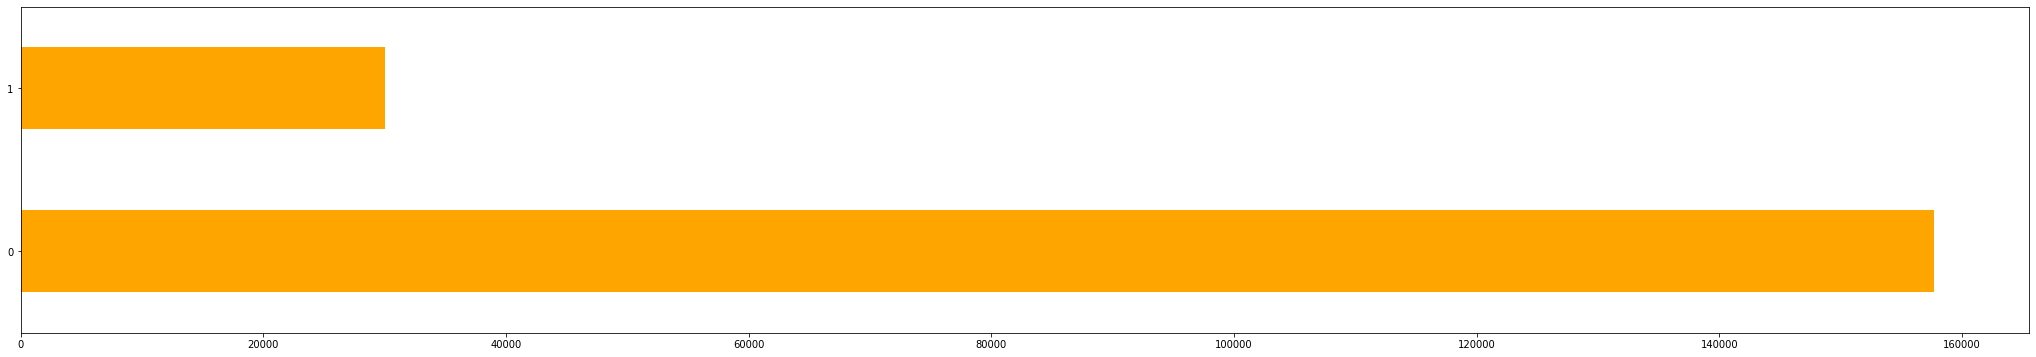

In [16]:
df2 = df_balanced["Purchase Event"].value_counts()
df2.plot(kind="barh", figsize=(36, 6), color='orange')
plt.show()

Bootstraping helped increase the sample size of the minority class, at least enough to help increase the prediction power of the models; albeit with a potential trade-off in regards to using artificial data. Below we repeat the same feature engineering process and training of the same models, now with the bootstrapped dataset.

In [17]:
conditions = [
    (df_balanced["Device Model (OS)"].str.contains("iP", case=False, na=False)),
    (df_balanced["Device Model (OS)"].str.contains("Redmi", case=False, na=False)),
    (df_balanced["Device Model (OS)"].str.contains("SM", case=False, na=False)),
]

values = ["iPhone/iPad", "Redmi", "Samsung"]
df_balanced["Mobiles"] = np.select(conditions, values)

df_balanced["Mobiles"] = np.where((df_balanced["Mobiles"] == "0"), "Other Devices", df_balanced["Mobiles"])

In [18]:
conditions = [
    (df_balanced["Acquired Campaign"] == "(direct)"),
    (df_balanced["Acquired Campaign"].str.contains("hard", case=False, na=False)),
    (df_balanced["Acquired Campaign"].str.contains("soft", case=False, na=False)),
    (df_balanced["Acquired Campaign"] == "iOS_US_Eng_Actions") | (df_balanced["Acquired Campaign"] == "AND_BR_Por_Actions") | (df_balanced["Acquired Campaign"] == "AND_US_Eng_Actions"),
    (df_balanced["Acquired Campaign"].isnull()),
]

values = ["Direct", "Hard", "Soft", "Other Sources", "Not categorzied"]
df_balanced["User Source Acquisition"] = np.select(conditions, values)

In [19]:
conditions = [
    (df_balanced["Country"] == "United States"),
    (df_balanced["Country"] == "Brazil"),
    (df_balanced["Country"] == "Canada"),
]

values = ["United States", "Brazil", "Canada"]
df_balanced["Countries Grouped"] = np.select(conditions, values)
df_balanced["Countries Grouped"] = np.where(df_balanced["Countries Grouped"] == "0", "Rest of World", df_balanced["Countries Grouped"])

In [20]:
ex2 = df_balanced[["User Source Acquisition", "Countries Grouped", "Platform", "Mobiles", "Purchase Event"]]

var = ex2[["User Source Acquisition", "Countries Grouped", "Platform", "Mobiles"]]
var = pd.get_dummies(var, drop_first=True)

In [21]:
y = ex2["Purchase Event"].values
x = var

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     31665
           1       0.61      0.02      0.04      5871

    accuracy                           0.84     37536
   macro avg       0.73      0.51      0.48     37536
weighted avg       0.81      0.84      0.78     37536

ROC: 0.5081618043904793


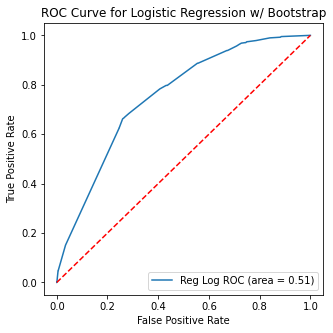

In [22]:
Reg_Log = LogisticRegression(random_state=10, max_iter=500).fit(x_train, y_train)

predict_Reg_Log = Reg_Log.predict(x_test)

ROC_Reg_Log = roc_auc_score(y_test, predict_Reg_Log)
print(metrics.classification_report(y_test, predict_Reg_Log))
print("ROC:", ROC_Reg_Log)

fpr, tpr, thresholds = roc_curve(y_test, Reg_Log.predict_proba(x_test)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label="Reg Log ROC (area = %0.2f)" % ROC_Reg_Log)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression w/ Bootstrap")
plt.legend(loc="lower right")
plt.savefig("Reg Log")
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.99      0.92     31665
           1       0.63      0.05      0.09      5871

    accuracy                           0.85     37536
   macro avg       0.74      0.52      0.50     37536
weighted avg       0.82      0.85      0.79     37536

ROC: 0.5217358184384445


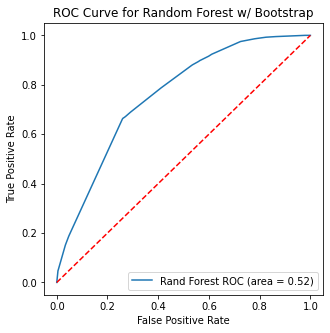

In [23]:
Rand_Forest_clasif = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    min_samples_split=5,
    max_depth=30,
    max_features="sqrt",
    bootstrap=True,
)

Rand_Forest_clasif.fit(x_train.values, y_train)

y_pred_Rand_Forest = Rand_Forest_clasif.predict(x_test.values)

ROC_Rand_Forest = roc_auc_score(y_test, y_pred_Rand_Forest)
print(classification_report(y_test, y_pred_Rand_Forest))
print("ROC:", ROC_Rand_Forest)

fpr, tpr, thresholds = roc_curve(y_test, Rand_Forest_clasif.predict_proba(x_test.values)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label="Rand Forest ROC (area = %0.2f)" % ROC_Rand_Forest)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest w/ Bootstrap")
plt.legend(loc="lower right")
plt.savefig("Rand Forest")
plt.show()

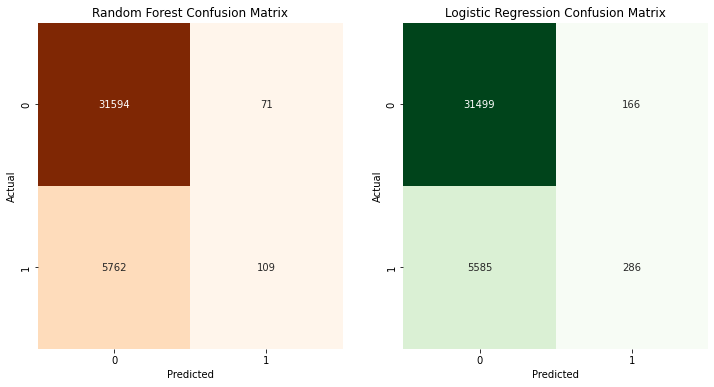

In [24]:
ran = confusion_matrix(y_test, y_pred_Rand_Forest)
log = confusion_matrix(y_test, predict_Reg_Log)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(log, annot=True, fmt="d", cmap="Oranges", cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Random Forest Confusion Matrix")

sns.heatmap(ran, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Logistic Regression Confusion Matrix")

plt.show()

Neither of these models, even with the Bootstrap resampling, are good enough to accurately predict whether a user will interact with the `in_app_purchase` event or not.

If we were to properly take on this predictive problem with a ML approach, we could do a couple of things: look to create an incredibly powerful & complex DL model, which I'm not particularly sure how it would work, or rediscuss the process of how the data is generated and  gathered. I'd personally go with the latter.

LP.